
# Audio Data Augmentation

**Author**: [Moto Hira](moto@meta.com)_

``torchaudio`` provides a variety of ways to augment audio data.

In this tutorial, we look into a way to apply effects, filters,
RIR (room impulse response) and codecs.

At the end, we synthesize noisy speech over phone from clean speech.


In [82]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

import os
import random

1.13.1+cu117
0.13.1+cu117


## Preparation

First, we import the modules and download the audio assets we use in this tutorial.




In [50]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [92]:
print(os.getcwd())
print(os.listdir("../../../datasets/GTZAN/gtzan_genre/genres/blues"))

/home/oriol_colome_font_epidemicsound_/Master-Thesis-1/utils/positive generator/torchaudio tutorials
['blues.00052.wav', 'blues.00092.wav', 'blues.00093.wav', 'blues.00070.wav', 'blues.00076.wav', 'blues.00058.wav', 'blues.00098.wav', 'blues.00073.wav', 'blues.00038.wav', 'blues.00034.wav', 'blues.00069.wav', 'blues.00064.wav', 'blues.00057.wav', 'blues.00097.wav', 'blues.00007.wav', 'blues.00040.wav', 'blues.00049.wav', 'blues.00000.wav', 'blues.00027.wav', 'blues.00077.wav', 'blues.00075.wav', 'blues.00001.wav', 'blues.00063.wav', 'blues.00003.wav', 'blues.00035.wav', 'blues.00046.wav', 'blues.00082.wav', 'blues.00025.wav', 'blues.00024.wav', 'blues.00039.wav', 'blues.00088.wav', 'blues.00022.wav', 'blues.00081.wav', 'blues.00014.wav', 'blues.00026.wav', 'blues.00066.wav', 'blues.00044.wav', 'blues.00036.wav', 'blues.00094.wav', 'blues.00016.wav', 'blues.00051.wav', 'blues.00078.wav', 'blues.00020.wav', 'blues.00099.wav', 'blues.00031.wav', 'blues.00048.wav', 'blues.00002.wav', 'blue

In [115]:
root = '../../../datasets/GTZAN/gtzan_genre/genres/'
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

test_list = []
for genre in genres:
    song = random.choice(os.listdir(root + genre))
    audio, sr = torchaudio.load(os.path.join(root, genre, song))
    test_list.append(['test_audio_' + str(genre), audio[:sr*10], sr])

print(test_list)

[['test_audio_blues', tensor([[-0.1386, -0.2097, -0.1781,  ..., -0.0951, -0.1024, -0.0964]]), 22050], ['test_audio_classical', tensor([[ 0.0053,  0.0032, -0.0018,  ..., -0.0016, -0.0022, -0.0020]]), 22050], ['test_audio_country', tensor([[ 0.0652,  0.1037,  0.0782,  ..., -0.1176, -0.1076, -0.1100]]), 22050], ['test_audio_disco', tensor([[0.0432, 0.0483, 0.0528,  ..., 0.2096, 0.1804, 0.1362]]), 22050], ['test_audio_hiphop', tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0385, -0.0423, -0.0518]]), 22050], ['test_audio_jazz', tensor([[0.0215, 0.0427, 0.0417,  ..., 0.0039, 0.0066, 0.0140]]), 22050], ['test_audio_metal', tensor([[-0.1224, -0.0492,  0.0444,  ..., -0.1784, -0.0840, -0.0285]]), 22050], ['test_audio_pop', tensor([[0.7692, 0.2246, 0.6904,  ..., 0.2122, 0.2169, 0.2437]]), 22050], ['test_audio_reggae', tensor([[ 1.2033e-01,  1.7001e-01,  1.8335e-01,  ..., -2.9541e-02,
          3.0518e-05,  2.3590e-02]]), 22050], ['test_audio_rock', tensor([[-0.0061,  0.0144,  0.0467,  ..., -0.0070,

## Applying effects and filtering

:py:func:`torchaudio.sox_effects` allows for directly applying filters similar to
those available in ``sox`` to Tensor objects and file object audio sources.

There are two functions for this:

-  :py:func:`torchaudio.sox_effects.apply_effects_tensor` for applying effects
   to Tensor.
-  :py:func:`torchaudio.sox_effects.apply_effects_file` for applying effects to
   other audio sources.

Both functions accept effect definitions in the form
``List[List[str]]``.
This is mostly consistent with how ``sox`` command works, but one caveat is
that ``sox`` adds some effects automatically, whereas ``torchaudio``’s
implementation does not.

For the list of available effects, please refer to [the sox
documentation](http://sox.sourceforge.net/sox.html)_.

**Tip** If you need to load and resample your audio data on the fly,
then you can use :py:func:`torchaudio.sox_effects.apply_effects_file`
with effect ``"rate"``.

**Note** :py:func:`torchaudio.sox_effects.apply_effects_file` accepts a
file-like object or path-like object.
Similar to :py:func:`torchaudio.load`, when the audio format cannot be
inferred from either the file extension or header, you can provide
argument ``format`` to specify the format of the audio source.

**Note** This process is not differentiable.




In [116]:
torchaudio.sox_effects.effect_names()

['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'biquad',
 'chorus',
 'channels',
 'compand',
 'contrast',
 'dcshift',
 'deemph',
 'delay',
 'dither',
 'divide',
 'downsample',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'fade',
 'fir',
 'firfit',
 'flanger',
 'gain',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'oops',
 'overdrive',
 'pad',
 'phaser',
 'pitch',
 'rate',
 'remix',
 'repeat',
 'reverb',
 'reverse',
 'riaa',
 'silence',
 'sinc',
 'speed',
 'stat',
 'stats',
 'stretch',
 'swap',
 'synth',
 'tempo',
 'treble',
 'tremolo',
 'trim',
 'upsample',
 'vad',
 'vol']

https://sox.sourceforge.net/sox.html#EFFECTS

In [117]:
effects_to_keep = ['allpass',
 'band',
 'bandpass',
 'bandreject',
 'bass',
 'bend',
 'chorus',
 'compand',
 'contrast',
 'delay',
 'dither',
 'divide',
 'earwax',
 'echo',
 'echos',
 'equalizer',
 'flanger',
 'highpass',
 'hilbert',
 'loudness',
 'lowpass',
 'mcompand',
 'norm',
 'overdrive',
 'phaser',
 'pitch',
 'reverb',
 'speed',
 'stretch',
 'tempo',
 'treble',
 'tremolo']

In [118]:
for audio in test_list:
    print(audio[0])
    Audio(audio[1], rate=audio[2])

test_audio_blues
test_audio_classical
test_audio_country
test_audio_disco
test_audio_hiphop
test_audio_jazz
test_audio_metal
test_audio_pop
test_audio_reggae
test_audio_rock


In [119]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

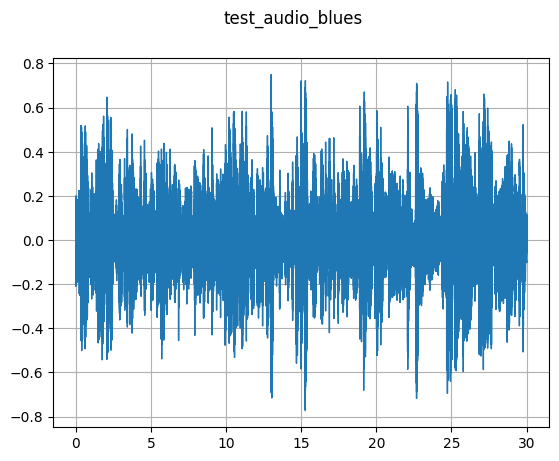

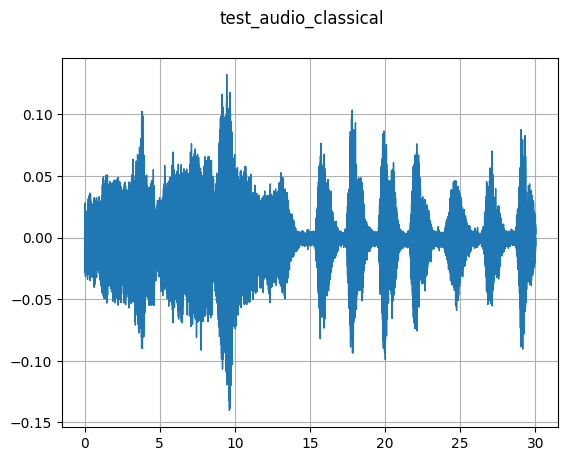

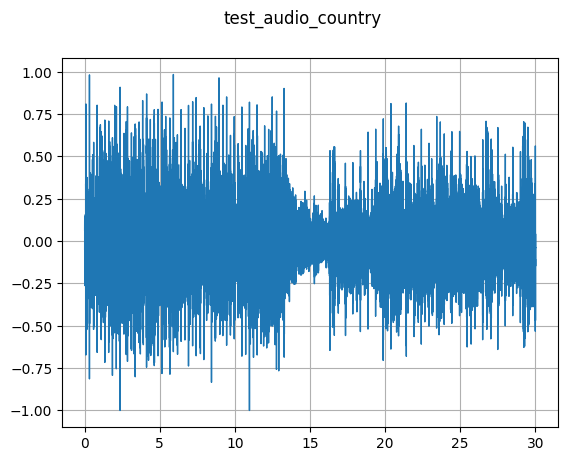

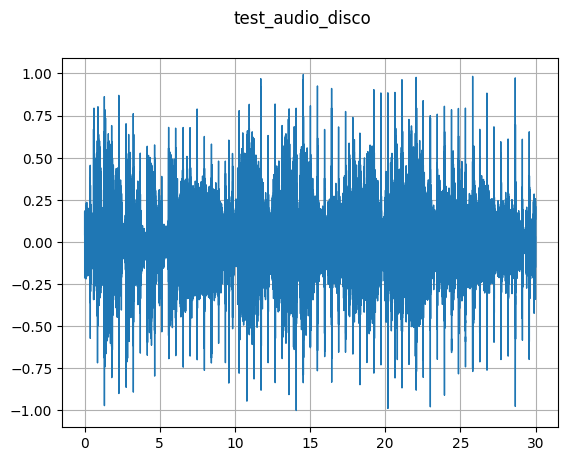

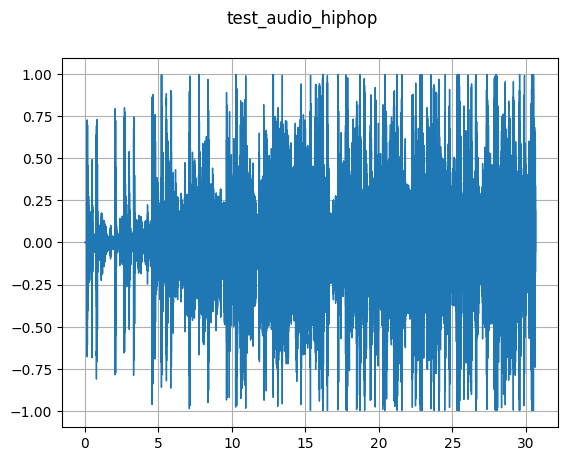

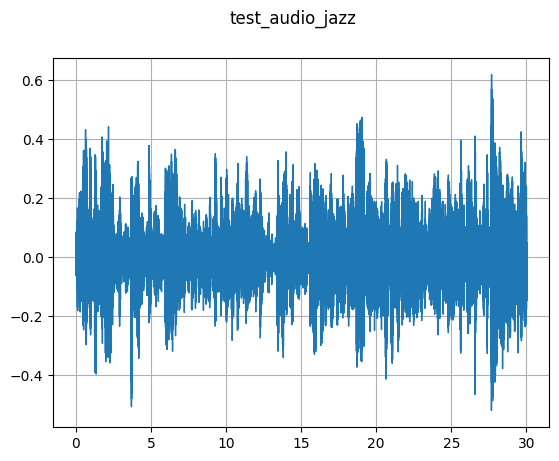

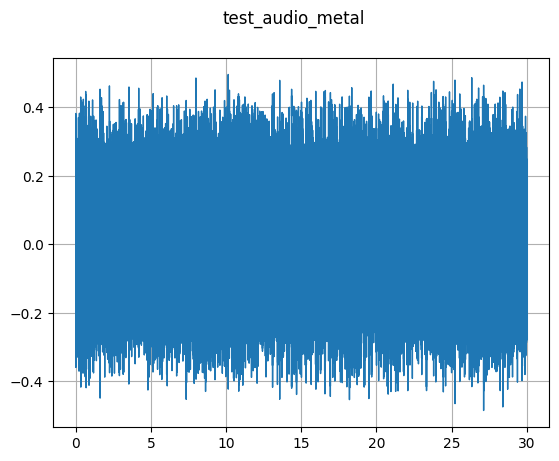

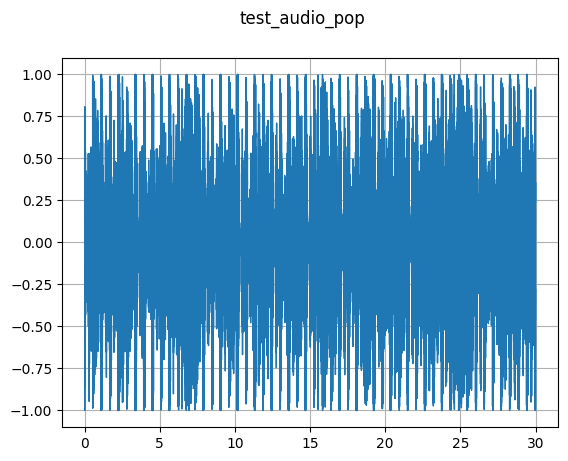

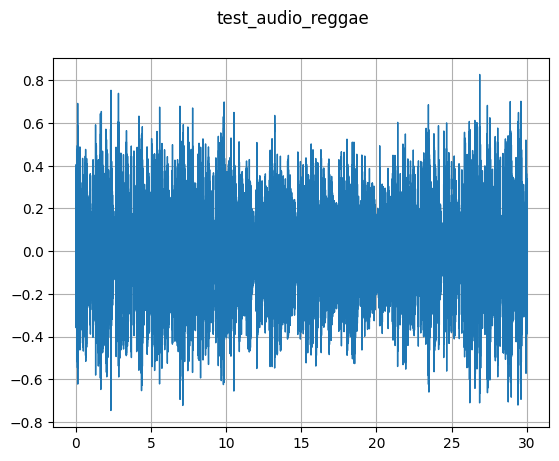

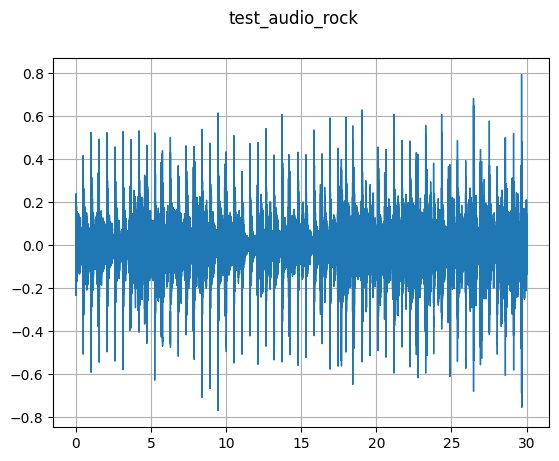

In [121]:
for audio in test_list:
    plot_waveform(audio[1], audio[2], title=str(audio[0]), xlim=None)

In [125]:
trans_list = []
for audio in test_list:
    # Define effects
    effects = [
        ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
        ["speed", "0.9"],  # reduce the speed
        # This only changes sample rate, so it is necessary to
        # add `rate` effect with original sample rate after this.
        ["rate", f"{audio[2]}"],
        ["reverb", "-w"],  # Reverbration gives some dramatic feeling
    ]

    # Apply effects
    y_trans, sr_trans = torchaudio.sox_effects.apply_effects_tensor(audio[1], audio[2], effects)
    trans_list.append([audio[0] + '_trans', y_trans, sr_trans])
    print(y_trans.shape)

torch.Size([2, 817030])
torch.Size([2, 735327])
torch.Size([2, 735327])
torch.Size([2, 735004])
torch.Size([2, 750898])
torch.Size([2, 735327])
torch.Size([2, 735004])
torch.Size([2, 735004])
torch.Size([2, 735004])
torch.Size([2, 735327])


### Effects applied:




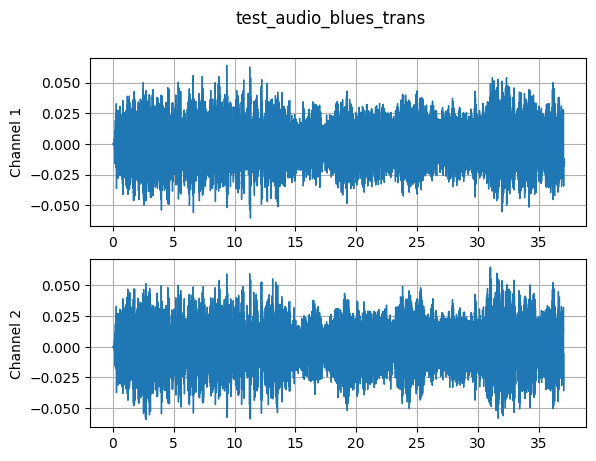

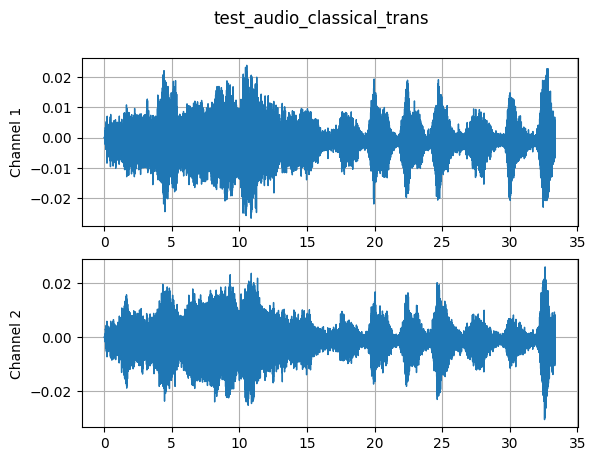

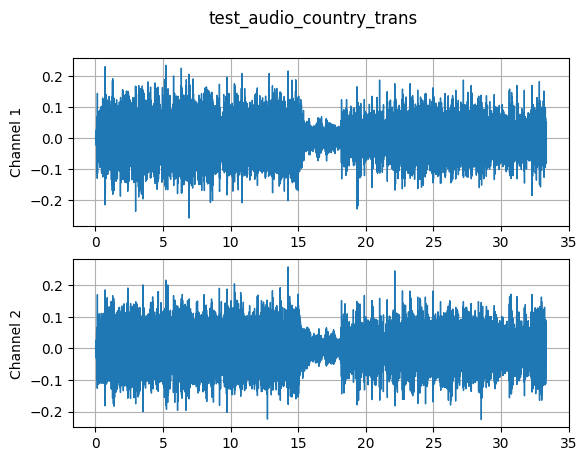

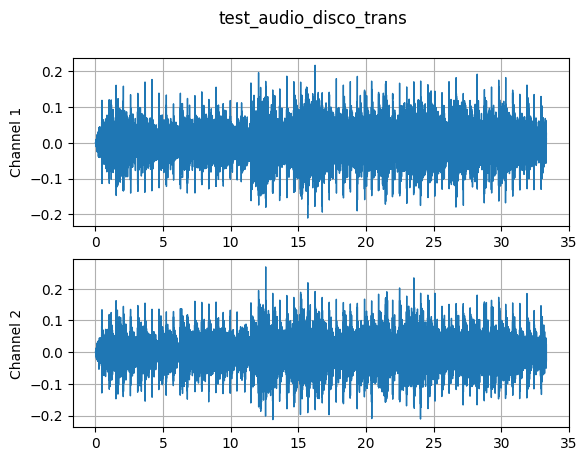

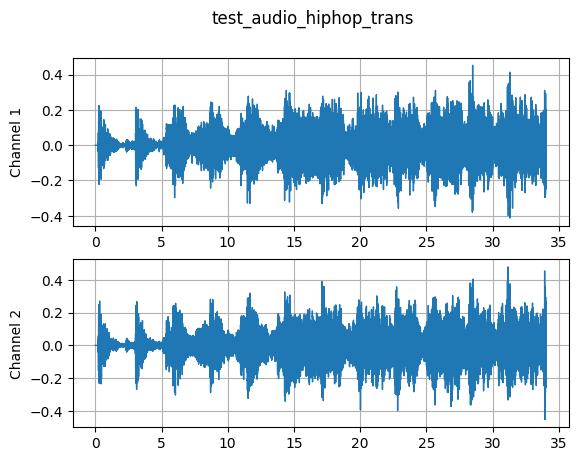

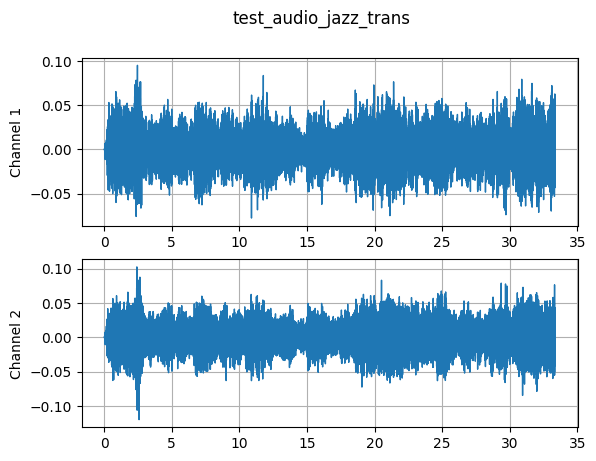

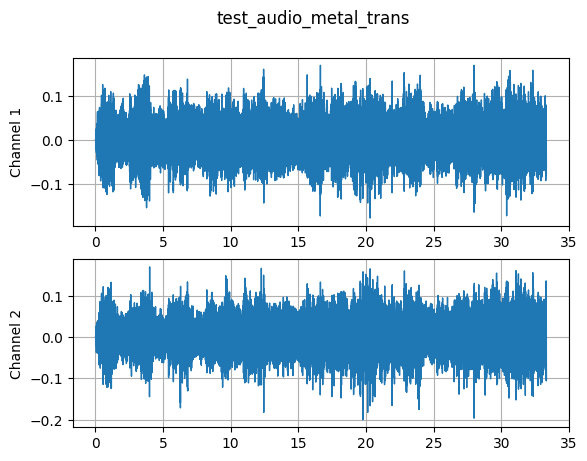

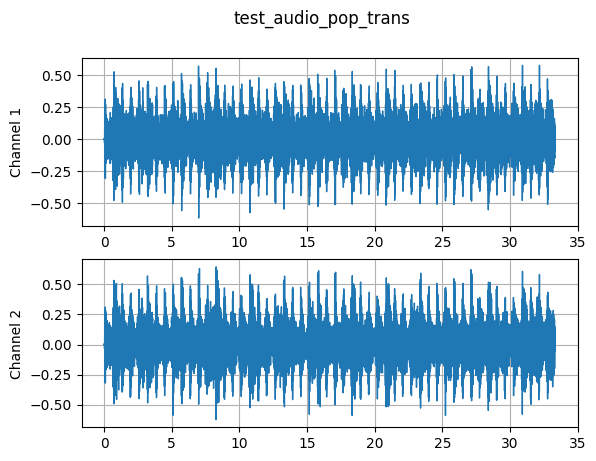

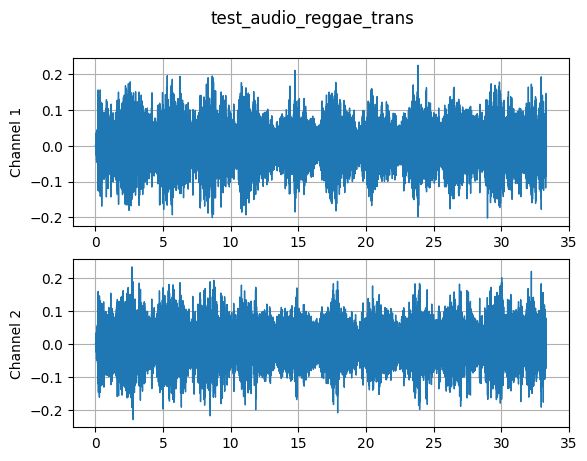

In [126]:
for audio in trans_list:
    plot_waveform(audio[1], audio[2], title=str(audio[0]), xlim=None)

In [ ]:
Audio(trans_list[0][1],trans_list[0][2])